# Method 7 - Best Ideas Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

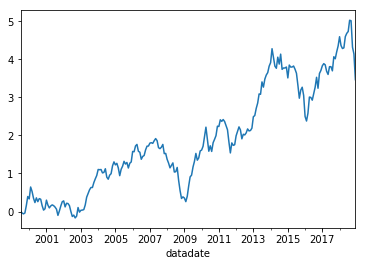

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.393963
2000-12-31   -0.230401
2001-12-31    0.171642
2002-12-31   -0.216566
2003-12-31    0.975845
2004-12-31    0.184293
2005-12-31   -0.000823
2006-12-31    0.181537
2007-12-31   -0.071234
2008-12-31   -0.451654
2009-12-31    0.870738
2010-12-31    0.250909
2011-12-31   -0.150722
2012-12-31    0.158739
2013-12-31    0.510529
2014-12-31   -0.004802
2015-12-31   -0.155532
2016-12-31    0.161647
2017-12-31    0.137073
2018-12-31   -0.165685
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     318.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.00e-92
Time:                        22:22:32   Log-Likelihood:                 506.50
No. Observations:                 234   AIC:                            -1003.
Df Residuals:                     229   BIC:                            -985.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.002      2.924      0.004       0.002       0.009
mktrf          0.8878      0.052     16.952      0.000       0.785       0.991
me             0.6381      0.061     10.474      0.000       0.518       0.758
ia             0.0023      0.093      0.025      0.980      -0.180       0.185
roe           -0.7527      0.079     -9.497      0.000      -0.909      -0.597
==============================================================================
Omnibus:                       36.436   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.425
Skew:                           0.738   Prob(JB):                     2.08e-18
Kurtosis:                       5.484   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.76e-66
Time:                        22:22:32   Log-Likelihood:                 506.50
No. Observations:                 234   AIC:                            -1003.
Df Residuals:                     229   BIC:                            -985.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.002      2.511      0.012       0.001       0.010
mktrf          0.8878      0.082     10.816      0.000       0.727       1.049
me             0.6381      0.065      9.767      0.000       0.510       0.766
ia             0.0023      0.143      0.016      0.987      -0.278       0.282
roe           -0.7527      0.139     -5.432      0.000      -1.024      -0.481
==============================================================================
Omnibus:                       36.436   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.425
Skew:                           0.738   Prob(JB):                     2.08e-18
Kurtosis:                       5.484   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     185.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.64e-70
Time:                        22:22:32   Log-Likelihood:                 506.50
No. Observations:                 234   AIC:                            -1003.
Df Residuals:                     229   BIC:                            -985.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.002      2.244      0.025       0.001       0.010
mktrf          0.8878      0.081     10.939      0.000       0.729       1.047
me             0.6381      0.072      8.852      0.000       0.497       0.779
ia             0.0023      0.127      0.018      0.986      -0.246       0.251
roe           -0.7527      0.141     -5.322      0.000      -1.030      -0.475
==============================================================================
Omnibus:                       36.436   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.425
Skew:                           0.738   Prob(JB):                     2.08e-18
Kurtosis:                       5.484   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     233.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.43e-87
Time:                        22:22:32   Log-Likelihood:                 498.44
No. Observations:                 234   AIC:                            -984.9
Df Residuals:                     228   BIC:                            -964.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.153      0.032       0.000       0.008
mktrf          1.0005      0.054     18.380      0.000       0.893       1.108
smb            0.7244      0.072     10.085      0.000       0.583       0.866
hml            0.0028      0.085      0.033      0.974      -0.164       0.170
rmw           -0.5623      0.096     -5.872      0.000      -0.751      -0.374
cma            0.1036      0.122      0.851      0.396      -0.136       0.343
==============================================================================
Omnibus:                       55.018   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.934
Skew:                           1.060   Prob(JB):                     1.84e-30
Kurtosis:                       6.090   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     152.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-70
Time:                        22:22:32   Log-Likelihood:                 498.44
No. Observations:                 234   AIC:                            -984.9
Df Residuals:                     228   BIC:                            -964.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      1.824      0.068      -0.000       0.009
mktrf          1.0005      0.063     15.850      0.000       0.877       1.124
smb            0.7244      0.086      8.413      0.000       0.556       0.893
hml            0.0028      0.133      0.021      0.983      -0.257       0.263
rmw           -0.5623      0.158     -3.561      0.000      -0.872      -0.253
cma            0.1036      0.167      0.621      0.535      -0.223       0.431
==============================================================================
Omnibus:                       55.018   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.934
Skew:                           1.060   Prob(JB):                     1.84e-30
Kurtosis:                       6.090   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     171.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.11e-75
Time:                        22:22:32   Log-Likelihood:                 498.44
No. Observations:                 234   AIC:                            -984.9
Df Residuals:                     228   BIC:                            -964.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.003      1.608      0.108      -0.001       0.010
mktrf          1.0005      0.058     17.238      0.000       0.887       1.114
smb            0.7244      0.083      8.757      0.000       0.562       0.886
hml            0.0028      0.131      0.021      0.983      -0.254       0.260
rmw           -0.5623      0.177     -3.184      0.001      -0.908      -0.216
cma            0.1036      0.151      0.687      0.492      -0.192       0.399
==============================================================================
Omnibus:                       55.018   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.934
Skew:                           1.060   Prob(JB):                     1.84e-30
Kurtosis:                       6.090   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     274.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.25e-86
Time:                        22:22:32   Log-Likelihood:                 492.00
No. Observations:                 234   AIC:                            -974.0
Df Residuals:                     229   BIC:                            -956.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.439      0.151      -0.001       0.007
mktrf          1.0397      0.051     20.266      0.000       0.939       1.141
smb            0.9580      0.064     14.960      0.000       0.832       1.084
hml           -0.0128      0.064     -0.200      0.841      -0.138       0.113
umd           -0.1964      0.042     -4.706      0.000      -0.279      -0.114
==============================================================================
Omnibus:                       35.828   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.381
Skew:                           0.670   Prob(JB):                     5.28e-21
Kurtosis:                       5.790   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     152.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.84e-63
Time:                        22:22:32   Log-Likelihood:                 492.00
No. Observations:                 234   AIC:                            -974.0
Df Residuals:                     229   BIC:                            -956.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.352      0.176      -0.001       0.007
mktrf          1.0397      0.069     15.169      0.000       0.905       1.174
smb            0.9580      0.056     17.217      0.000       0.849       1.067
hml           -0.0128      0.108     -0.118      0.906      -0.225       0.199
umd           -0.1964      0.065     -3.018      0.003      -0.324      -0.069
==============================================================================
Omnibus:                       35.828   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.381
Skew:                           0.670   Prob(JB):                     5.28e-21
Kurtosis:                       5.790   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     139.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.63e-60
Time:                        22:22:32   Log-Likelihood:                 492.00
No. Observations:                 234   AIC:                            -974.0
Df Residuals:                     229   BIC:                            -956.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.238      0.216      -0.002       0.007
mktrf          1.0397      0.060     17.251      0.000       0.922       1.158
smb            0.9580      0.054     17.609      0.000       0.851       1.065
hml           -0.0128      0.107     -0.119      0.905      -0.223       0.198
umd           -0.1964      0.065     -3.016      0.003      -0.324      -0.069
==============================================================================
Omnibus:                       35.828   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.381
Skew:                           0.670   Prob(JB):                     5.28e-21
Kurtosis:                       5.790   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     144.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.40e-44
Time:                        22:22:32   Log-Likelihood:                 234.83
No. Observations:                 120   AIC:                            -459.7
Df Residuals:                     115   BIC:                            -445.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.003      3.061      0.003       0.004       0.017
mktrf          0.8849      0.090      9.830      0.000       0.707       1.063
me             0.6387      0.089      7.184      0.000       0.463       0.815
ia            -0.1087      0.139     -0.781      0.437      -0.384       0.167
roe           -0.6991      0.123     -5.674      0.000      -0.943      -0.455
==============================================================================
Omnibus:                       10.300   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.929
Skew:                           0.533   Prob(JB):                      0.00257
Kurtosis:                       4.118   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     121.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.89e-40
Time:                        22:22:32   Log-Likelihood:                 234.83
No. Observations:                 120   AIC:                            -459.7
Df Residuals:                     115   BIC:                            -445.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.004      2.811      0.005       0.003       0.017
mktrf          0.8849      0.139      6.366      0.000       0.612       1.157
me             0.6387      0.102      6.286      0.000       0.440       0.838
ia            -0.1087      0.203     -0.536      0.592      -0.506       0.289
roe           -0.6991      0.218     -3.209      0.001      -1.126      -0.272
==============================================================================
Omnibus:                       10.300   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.929
Skew:                           0.533   Prob(JB):                      0.00257
Kurtosis:                       4.118   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     140.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.81e-43
Time:                        22:22:32   Log-Likelihood:                 234.83
No. Observations:                 120   AIC:                            -459.7
Df Residuals:                     115   BIC:                            -445.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.004      2.524      0.012       0.002       0.018
mktrf          0.8849      0.138      6.426      0.000       0.615       1.155
me             0.6387      0.115      5.553      0.000       0.413       0.864
ia            -0.1087      0.180     -0.604      0.546      -0.461       0.244
roe           -0.6991      0.224     -3.119      0.002      -1.138      -0.260
==============================================================================
Omnibus:                       10.300   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.929
Skew:                           0.533   Prob(JB):                      0.00257
Kurtosis:                       4.118   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     115.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.90e-43
Time:                        22:22:32   Log-Likelihood:                 235.17
No. Observations:                 120   AIC:                            -458.3
Df Residuals:                     114   BIC:                            -441.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.003      2.876      0.005       0.003       0.017
mktrf          1.0790      0.095     11.350      0.000       0.891       1.267
smb            0.7511      0.108      6.976      0.000       0.538       0.964
hml           -0.1094      0.132     -0.829      0.409      -0.371       0.152
rmw           -0.4384      0.156     -2.818      0.006      -0.747      -0.130
cma            0.1374      0.170      0.806      0.422      -0.200       0.475
==============================================================================
Omnibus:                       18.240   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.890
Skew:                           0.771   Prob(JB):                     2.39e-06
Kurtosis:                       4.673   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     84.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-36
Time:                        22:22:32   Log-Likelihood:                 235.17
No. Observations:                 120   AIC:                            -458.3
Df Residuals:                     114   BIC:                            -441.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.004      2.605      0.009       0.002       0.017
mktrf          1.0790      0.108      9.998      0.000       0.867       1.291
smb            0.7511      0.131      5.744      0.000       0.495       1.007
hml           -0.1094      0.184     -0.595      0.552      -0.470       0.251
rmw           -0.4384      0.246     -1.783      0.075      -0.920       0.043
cma            0.1374      0.191      0.720      0.471      -0.236       0.511
==============================================================================
Omnibus:                       18.240   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.890
Skew:                           0.771   Prob(JB):                     2.39e-06
Kurtosis:                       4.673   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     98.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.46e-40
Time:                        22:22:32   Log-Likelihood:                 235.17
No. Observations:                 120   AIC:                            -458.3
Df Residuals:                     114   BIC:                            -441.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.004      2.300      0.021       0.001       0.018
mktrf          1.0790      0.100     10.785      0.000       0.883       1.275
smb            0.7511      0.136      5.541      0.000       0.485       1.017
hml           -0.1094      0.186     -0.587      0.557      -0.475       0.256
rmw           -0.4384      0.275     -1.592      0.111      -0.978       0.101
cma            0.1374      0.162      0.851      0.395      -0.179       0.454
==============================================================================
Omnibus:                       18.240   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.890
Skew:                           0.771   Prob(JB):                     2.39e-06
Kurtosis:                       4.673   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     144.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.85e-44
Time:                        22:22:32   Log-Likelihood:                 234.91
No. Observations:                 120   AIC:                            -459.8
Df Residuals:                     115   BIC:                            -445.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.003      2.568      0.012       0.002       0.015
mktrf          1.0777      0.079     13.599      0.000       0.921       1.235
smb            0.9635      0.090     10.679      0.000       0.785       1.142
hml           -0.0757      0.090     -0.837      0.404      -0.255       0.103
umd           -0.1969      0.056     -3.533      0.001      -0.307      -0.087
==============================================================================
Omnibus:                       11.103   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               17.114
Skew:                           0.434   Prob(JB):                     0.000192
Kurtosis:                       4.634   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     92.07
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.31e-35
Time:                        22:22:32   Log-Likelihood:                 234.91
No. Observations:                 120   AIC:                            -459.8
Df Residuals:                     115   BIC:                            -445.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.003      2.954      0.003       0.003       0.014
mktrf          1.0777      0.104     10.394      0.000       0.874       1.281
smb            0.9635      0.084     11.439      0.000       0.798       1.129
hml           -0.0757      0.154     -0.492      0.623      -0.377       0.226
umd           -0.1969      0.072     -2.745      0.006      -0.337      -0.056
==============================================================================
Omnibus:                       11.103   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               17.114
Skew:                           0.434   Prob(JB):                     0.000192
Kurtosis:                       4.634   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     80.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.71e-32
Time:                        22:22:32   Log-Likelihood:                 234.91
No. Observations:                 120   AIC:                            -459.8
Df Residuals:                     115   BIC:                            -445.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.003      2.869      0.004       0.003       0.014
mktrf          1.0777      0.090     12.018      0.000       0.902       1.253
smb            0.9635      0.080     12.089      0.000       0.807       1.120
hml           -0.0757      0.160     -0.472      0.637      -0.390       0.238
umd           -0.1969      0.068     -2.901      0.004      -0.330      -0.064
==============================================================================
Omnibus:                       11.103   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               17.114
Skew:                           0.434   Prob(JB):                     0.000192
Kurtosis:                       4.634   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     263.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.97e-55
Time:                        22:22:32   Log-Likelihood:                 304.58
No. Observations:                 114   AIC:                            -599.2
Df Residuals:                     109   BIC:                            -585.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.289      0.773      -0.003       0.004
mktrf          0.9516      0.050     18.921      0.000       0.852       1.051
me             0.5207      0.078      6.706      0.000       0.367       0.675
ia             0.1648      0.108      1.530      0.129      -0.049       0.378
roe           -0.9110      0.095     -9.626      0.000      -1.099      -0.723
==============================================================================
Omnibus:                        1.299   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                1.342
Skew:                          -0.186   Prob(JB):                        0.511
Kurtosis:                       2.620   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     501.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.44e-69
Time:                        22:22:32   Log-Likelihood:                 304.58
No. Observations:                 114   AIC:                            -599.2
Df Residuals:                     109   BIC:                            -585.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.323      0.747      -0.002       0.003
mktrf          0.9516      0.055     17.222      0.000       0.843       1.060
me             0.5207      0.056      9.257      0.000       0.410       0.631
ia             0.1648      0.111      1.487      0.137      -0.052       0.382
roe           -0.9110      0.139     -6.555      0.000      -1.183      -0.639
==============================================================================
Omnibus:                        1.299   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                1.342
Skew:                          -0.186   Prob(JB):                        0.511
Kurtosis:                       2.620   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     490.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-68
Time:                        22:22:32   Log-Likelihood:                 304.58
No. Observations:                 114   AIC:                            -599.2
Df Residuals:                     109   BIC:                            -585.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.352      0.725      -0.002       0.003
mktrf          0.9516      0.056     16.901      0.000       0.841       1.062
me             0.5207      0.056      9.243      0.000       0.410       0.631
ia             0.1648      0.101      1.630      0.103      -0.033       0.363
roe           -0.9110      0.116     -7.867      0.000      -1.138      -0.684
==============================================================================
Omnibus:                        1.299   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                1.342
Skew:                          -0.186   Prob(JB):                        0.511
Kurtosis:                       2.620   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     152.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.24e-47
Time:                        22:22:32   Log-Likelihood:                 288.55
No. Observations:                 114   AIC:                            -565.1
Df Residuals:                     108   BIC:                            -548.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.854      0.395      -0.006       0.002
mktrf          1.0042      0.055     18.105      0.000       0.894       1.114
smb            0.5967      0.090      6.627      0.000       0.418       0.775
hml            0.1043      0.115      0.908      0.366      -0.123       0.332
rmw           -0.7163      0.141     -5.094      0.000      -0.995      -0.438
cma            0.0784      0.179      0.439      0.661      -0.275       0.432
==============================================================================
Omnibus:                       11.047   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               16.726
Skew:                           0.451   Prob(JB):                     0.000233
Kurtosis:                       4.645   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     139.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.16e-45
Time:                        22:22:32   Log-Likelihood:                 288.55
No. Observations:                 114   AIC:                            -565.1
Df Residuals:                     108   BIC:                            -548.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.832      0.405      -0.006       0.002
mktrf          1.0042      0.060     16.762      0.000       0.887       1.122
smb            0.5967      0.093      6.404      0.000       0.414       0.779
hml            0.1043      0.115      0.911      0.363      -0.120       0.329
rmw           -0.7163      0.230     -3.112      0.002      -1.167      -0.265
cma            0.0784      0.146      0.538      0.591      -0.207       0.364
==============================================================================
Omnibus:                       11.047   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               16.726
Skew:                           0.451   Prob(JB):                     0.000233
Kurtosis:                       4.645   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     127.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-43
Time:                        22:22:32   Log-Likelihood:                 288.55
No. Observations:                 114   AIC:                            -565.1
Df Residuals:                     108   BIC:                            -548.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.879      0.379      -0.005       0.002
mktrf          1.0042      0.066     15.253      0.000       0.875       1.133
smb            0.5967      0.104      5.730      0.000       0.393       0.801
hml            0.1043      0.124      0.843      0.399      -0.138       0.347
rmw           -0.7163      0.261     -2.748      0.006      -1.227      -0.205
cma            0.0784      0.163      0.481      0.631      -0.241       0.398
==============================================================================
Omnibus:                       11.047   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               16.726
Skew:                           0.451   Prob(JB):                     0.000233
Kurtosis:                       4.645   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     152.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.12e-43
Time:                        22:22:32   Log-Likelihood:                 277.18
No. Observations:                 114   AIC:                            -544.4
Df Residuals:                     109   BIC:                            -530.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.002     -1.221      0.225      -0.007       0.002
mktrf          1.0422      0.061     17.196      0.000       0.922       1.162
smb            0.7576      0.095      8.016      0.000       0.570       0.945
hml            0.2232      0.097      2.293      0.024       0.030       0.416
umd           -0.1168      0.073     -1.591      0.114      -0.262       0.029
==============================================================================
Omnibus:                       17.748   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.569
Skew:                           0.568   Prob(JB):                     2.56e-09
Kurtosis:                       5.653   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     251.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.08e-54
Time:                        22:22:32   Log-Likelihood:                 277.18
No. Observations:                 114   AIC:                            -544.4
Df Residuals:                     109   BIC:                            -530.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.002     -1.324      0.186      -0.007       0.001
mktrf          1.0422      0.057     18.316      0.000       0.931       1.154
smb            0.7576      0.092      8.269      0.000       0.578       0.937
hml            0.2232      0.102      2.194      0.028       0.024       0.423
umd           -0.1168      0.052     -2.260      0.024      -0.218      -0.015
==============================================================================
Omnibus:                       17.748   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.569
Skew:                           0.568   Prob(JB):                     2.56e-09
Kurtosis:                       5.653   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     311.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.13e-58
Time:                        22:22:32   Log-Likelihood:                 277.18
No. Observations:                 114   AIC:                            -544.4
Df Residuals:                     109   BIC:                            -530.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.002     -1.318      0.188      -0.007       0.001
mktrf          1.0422      0.058     17.819      0.000       0.928       1.157
smb            0.7576      0.075     10.103      0.000       0.611       0.905
hml            0.2232      0.098      2.277      0.023       0.031       0.415
umd           -0.1168      0.041     -2.825      0.005      -0.198      -0.036
==============================================================================
Omnibus:                       17.748   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.569
Skew:                           0.568   Prob(JB):                     2.56e-09
Kurtosis:                       5.653   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""